In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# !pip install mpi4py
# !pip install celluloid

In [3]:
def live(grid):
    n = grid.shape[0]
    m = grid.shape[1]
    exp_grid = np.zeros(shape=(n+2, m+2))
    exp_grid[0,0] = grid[-1,-1].copy()
    exp_grid[0,-1] = grid[-1,0].copy()
    exp_grid[-1,0] = grid[0, -1].copy()
    exp_grid[-1,-1] = grid[0,0].copy()
    exp_grid[1:-1, 0] = grid[:, -1].copy()
    exp_grid[1:-1, -1] = grid[:, 0].copy()
    exp_grid[0, 1:-1] = grid[-1, :].copy()
    exp_grid[-1, 1:-1] = grid[0, :].copy()
    exp_grid[1:-1, 1:-1] = grid.copy()
    
    new_grid = grid.copy()
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            hood = np.sum(exp_grid[i:i+3, j:j+3])-grid[i][j]
            if grid[i][j] == 0 and hood == 3:
                new_grid[i][j] = 1
            elif grid[i,j] == 1 and ((hood<=1) or (hood>=4)):
                new_grid[i][j] = 0
    
    
    return new_grid

In [4]:
# sequential
n = 10
grid = np.random.binomial(1,0.5, size=(n,n))
for i in range(100):
    grid = live(grid)

In [10]:
%%writefile gosper.py
from mpi4py import MPI
import numpy as np

# Gosper glider gun
gun = np.zeros(38*38).reshape(38, 38)
 
gun[5][1] = 1
gun[5][2] = 1
gun[6][1] = 1
gun[6][2] = 1

gun[3][13] = gun[3][14] = 1
gun[4][12] = gun[4][16] = 1
gun[5][11] = gun[5][17] = 1
gun[6][11] = gun[6][15] = gun[6][17] = gun[6][18] = 1
gun[7][11] = gun[7][17] = 1
gun[8][12] = gun[8][16] = 1
gun[9][13] = gun[9][14] = 1

gun[1][25] = 1
gun[2][23] = gun[2][25] = 1
gun[3][21] = gun[3][22] = 1
gun[4][21] = gun[4][22] = 1
gun[5][21] = gun[5][22] = 1
gun[6][23] = gun[6][25] = 1
gun[7][25] = 1

gun[3][35] = gun[3][36] = 1
gun[4][35] = gun[4][36] = 1

start =  MPI.Wtime()

comm = MPI.COMM_WORLD
size=comm.Get_size()
rank=comm.Get_rank()

from matplotlib import pyplot as plt
from celluloid import Camera
 
grid = gun.copy()

row_block = grid.shape[0]//size
grid_block = grid[rank*row_block:(rank+1)*row_block]
n = grid_block.shape[0]
m = grid_block.shape[1]

if rank == 0:
    fig = plt.figure()
    camera = Camera(fig)

for step in range(100):
    if rank == size-1:
        comm.isend(grid_block[0].shape, dest = rank-1)
        comm.Send(grid_block[0], dest = rank-1)
        comm.isend(grid_block[-1].shape, dest = 0)
        comm.Send(grid_block[-1], dest = 0)
    elif rank == 0:
        comm.isend(grid_block[0].shape, dest = size-1)
        comm.Send(grid_block[0], dest = size-1)
        comm.isend(grid_block[-1].shape, dest = rank+1)
        comm.Send(grid_block[-1], dest = rank+1)
    else:
        comm.isend(grid_block[0].shape, dest = rank-1)
        comm.Send(grid_block[0], dest = rank-1)
        comm.isend(grid_block[-1].shape, dest = rank+1)
        comm.Send(grid_block[-1], dest = rank+1)
    if rank == size-1:
        shape = comm.recv(source = rank-1)
        first = np.empty(shape, dtype = 'd')
        comm.Recv(first, source = rank-1)
        shape = comm.recv(source = 0)
        last = np.empty(shape, dtype = 'd')
        comm.Recv(last, source = 0)
    elif rank == 0:
        shape = comm.recv(source = size-1)
        first = np.empty(shape, dtype = 'd')
        comm.Recv(first, source = size-1)
        shape = comm.recv(source = rank+1)
        last = np.empty(shape, dtype = 'd')
        comm.Recv(last, source = rank+1)
    else:
        shape = comm.recv(source = rank-1)
        first = np.empty(shape, dtype = 'd')
        comm.Recv(first, source = rank-1)
        shape = comm.recv(source = rank+1)
        last = np.empty(shape, dtype = 'd')
        comm.Recv(last, source = rank+1)

    exp_grid = np.zeros(shape=(n+2, m+2))
    exp_grid[0,0] = first[-1].copy()
    exp_grid[0,-1] = first[0].copy()
    exp_grid[-1,0] = last[-1].copy()
    exp_grid[-1,-1] = last[0].copy()
    exp_grid[1:-1, 0] = grid_block[:, -1].copy()
    exp_grid[1:-1, -1] = grid_block[:, 0].copy()
    exp_grid[0, 1:-1] = first.copy()
    exp_grid[-1, 1:-1] = last.copy()
    exp_grid[1:-1, 1:-1] = grid_block.copy()
    
    new_grid_block = grid_block.copy()
    for i in range(grid_block.shape[0]):
        for j in range(grid_block.shape[1]):
            hood = np.sum(exp_grid[i:i+3, j:j+3])-grid_block[i][j]
            if grid_block[i][j] == 0 and hood == 3:
                new_grid_block[i][j] = 1
            elif grid_block[i,j] == 1 and ((hood<=1) or (hood>=4)):
                new_grid_block[i][j] = 0

    grid_block = new_grid_block.copy()

    new_grid = comm.gather(new_grid_block, root=0)
    if rank == 0:
        new_grid = np.concatenate(new_grid, axis=0)
        plt.axis('off')
        plt.imshow(new_grid)
        camera.snap()


if rank == 0:
    animation = camera.animate()
    animation.save(f'Gosper_glider_gun.gif', writer = 'pillow', fps=10)


end = MPI.Wtime()

if rank==0:
    print(end-start)

Writing gosper.py


In [16]:
!mpirun --allow-run-as-root -n 3 python gosper.py

56.85844635500143


In [20]:
%%writefile simkin.py
from mpi4py import MPI
import numpy as np

# 36-cell Simkin gun
gun = np.zeros(36*36).reshape(36, 36)

gun[1:3, 1:3] = 1
gun[1:3, 8:10] = 1

gun[4:6, 5:7] = 1

gun[10, 23:25] = 1
gun[10, 26:28] = 1

gun[11:14, 22] = 1
gun[11, 28] = 1
gun[12, 29] = 1
gun[12:14, 32:34] = 1
gun[13, 23:25] = 1
gun[13, 28] = 1
gun[14, 27] = 1

gun[18, 21:23] = 1
gun[19, 21] = 1
gun[20, 22:25] = 1
gun[21, 24] = 1


start =  MPI.Wtime()

comm = MPI.COMM_WORLD
size=comm.Get_size()
rank=comm.Get_rank()

from matplotlib import pyplot as plt
from celluloid import Camera
 
grid = gun.copy()

row_block = grid.shape[0]//size
grid_block = grid[rank*row_block:(rank+1)*row_block]
n = grid_block.shape[0]
m = grid_block.shape[1]

if rank == 0:
    fig = plt.figure()
    camera = Camera(fig)

for step in range(100):
    if rank == size-1:
        comm.isend(grid_block[0].shape, dest = rank-1)
        comm.Send(grid_block[0], dest = rank-1)
        comm.isend(grid_block[-1].shape, dest = 0)
        comm.Send(grid_block[-1], dest = 0)
    elif rank == 0:
        comm.isend(grid_block[0].shape, dest = size-1)
        comm.Send(grid_block[0], dest = size-1)
        comm.isend(grid_block[-1].shape, dest = rank+1)
        comm.Send(grid_block[-1], dest = rank+1)
    else:
        comm.isend(grid_block[0].shape, dest = rank-1)
        comm.Send(grid_block[0], dest = rank-1)
        comm.isend(grid_block[-1].shape, dest = rank+1)
        comm.Send(grid_block[-1], dest = rank+1)
    if rank == size-1:
        shape = comm.recv(source = rank-1)
        first = np.empty(shape, dtype = 'd')
        comm.Recv(first, source = rank-1)
        shape = comm.recv(source = 0)
        last = np.empty(shape, dtype = 'd')
        comm.Recv(last, source = 0)
    elif rank == 0:
        shape = comm.recv(source = size-1)
        first = np.empty(shape, dtype = 'd')
        comm.Recv(first, source = size-1)
        shape = comm.recv(source = rank+1)
        last = np.empty(shape, dtype = 'd')
        comm.Recv(last, source = rank+1)
    else:
        shape = comm.recv(source = rank-1)
        first = np.empty(shape, dtype = 'd')
        comm.Recv(first, source = rank-1)
        shape = comm.recv(source = rank+1)
        last = np.empty(shape, dtype = 'd')
        comm.Recv(last, source = rank+1)

    exp_grid = np.zeros(shape=(n+2, m+2))
    exp_grid[0,0] = first[-1].copy()
    exp_grid[0,-1] = first[0].copy()
    exp_grid[-1,0] = last[-1].copy()
    exp_grid[-1,-1] = last[0].copy()
    exp_grid[1:-1, 0] = grid_block[:, -1].copy()
    exp_grid[1:-1, -1] = grid_block[:, 0].copy()
    exp_grid[0, 1:-1] = first.copy()
    exp_grid[-1, 1:-1] = last.copy()
    exp_grid[1:-1, 1:-1] = grid_block.copy()
    
    new_grid_block = grid_block.copy()
    for i in range(grid_block.shape[0]):
        for j in range(grid_block.shape[1]):
            hood = np.sum(exp_grid[i:i+3, j:j+3])-grid_block[i][j]
            if grid_block[i][j] == 0 and hood == 3:
                new_grid_block[i][j] = 1
            elif grid_block[i,j] == 1 and ((hood<=1) or (hood>=4)):
                new_grid_block[i][j] = 0

    grid_block = new_grid_block.copy()

    new_grid = comm.gather(new_grid_block, root=0)
    if rank == 0:
        new_grid = np.concatenate(new_grid, axis=0)
        plt.axis('off')
        plt.imshow(new_grid)
        camera.snap()


if rank == 0:
    animation = camera.animate()
    animation.save(f'Simkin_glider_gun.gif', writer = 'pillow', fps=10)


end = MPI.Wtime()

if rank==0:
    print(end-start)

Overwriting simkin.py


In [21]:
!mpirun --allow-run-as-root -n 3 python simkin.py

58.402634808000585


In [46]:
%%writefile test.py
from mpi4py import MPI
import numpy as np

start =  MPI.Wtime()

comm = MPI.COMM_WORLD
size=comm.Get_size()
rank=comm.Get_rank()

from matplotlib import pyplot as plt
from celluloid import Camera
 
n = 20
np.random.seed(8)
grid = np.random.binomial(1,0.5, size=(n,n))

row_block = grid.shape[0]//size
grid_block = grid[rank*row_block:(rank+1)*row_block]
n = grid_block.shape[0]
m = grid_block.shape[1]

if rank == 0:
    fig = plt.figure()
    camera = Camera(fig)

for step in range(100):
    if rank == size-1:
        comm.isend(grid_block[0].shape, dest = rank-1)
        comm.Send(grid_block[0], dest = rank-1)
        comm.isend(grid_block[-1].shape, dest = 0)
        comm.Send(grid_block[-1], dest = 0)
    elif rank == 0:
        comm.isend(grid_block[0].shape, dest = size-1)
        comm.Send(grid_block[0], dest = size-1)
        comm.isend(grid_block[-1].shape, dest = rank+1)
        comm.Send(grid_block[-1], dest = rank+1)
    else:
        comm.isend(grid_block[0].shape, dest = rank-1)
        comm.Send(grid_block[0], dest = rank-1)
        comm.isend(grid_block[-1].shape, dest = rank+1)
        comm.Send(grid_block[-1], dest = rank+1)
    if rank == size-1:
        shape = comm.recv(source = rank-1)
        first = np.empty(shape, dtype = 'd')
        comm.Recv(first, source = rank-1)
        shape = comm.recv(source = 0)
        last = np.empty(shape, dtype = 'd')
        comm.Recv(last, source = 0)
    elif rank == 0:
        shape = comm.recv(source = size-1)
        first = np.empty(shape, dtype = 'd')
        comm.Recv(first, source = size-1)
        shape = comm.recv(source = rank+1)
        last = np.empty(shape, dtype = 'd')
        comm.Recv(last, source = rank+1)
    else:
        shape = comm.recv(source = rank-1)
        first = np.empty(shape, dtype = 'd')
        comm.Recv(first, source = rank-1)
        shape = comm.recv(source = rank+1)
        last = np.empty(shape, dtype = 'd')
        comm.Recv(last, source = rank+1)

    exp_grid = np.zeros(shape=(n+2, m+2))
    exp_grid[0,0] = first[-1].copy()
    exp_grid[0,-1] = first[0].copy()
    exp_grid[-1,0] = last[-1].copy()
    exp_grid[-1,-1] = last[0].copy()
    exp_grid[1:-1, 0] = grid_block[:, -1].copy()
    exp_grid[1:-1, -1] = grid_block[:, 0].copy()
    exp_grid[0, 1:-1] = first.copy()
    exp_grid[-1, 1:-1] = last.copy()
    exp_grid[1:-1, 1:-1] = grid_block.copy()
    
    new_grid_block = grid_block.copy()
    for i in range(grid_block.shape[0]):
        for j in range(grid_block.shape[1]):
            hood = np.sum(exp_grid[i:i+3, j:j+3])-grid_block[i][j]
            if grid_block[i][j] == 0 and hood == 3:
                new_grid_block[i][j] = 1
            elif grid_block[i,j] == 1 and ((hood<=1) or (hood>=4)):
                new_grid_block[i][j] = 0

    grid_block = new_grid_block.copy()

    new_grid = comm.gather(new_grid_block, root=0)
    if rank == 0:
        new_grid = np.concatenate(new_grid, axis=0)
        plt.axis('off')
        plt.imshow(new_grid)
        camera.snap()


if rank == 0:
    animation = camera.animate()
    animation.save(f'Random_gun.gif', writer = 'pillow', fps=10)


end = MPI.Wtime()

if rank==0:
    print(end-start)

Overwriting test.py


In [47]:
!mpirun --allow-run-as-root -n 3 python test.py

47.55457481299891


In [26]:
# Gosper glider gun
gun = np.zeros(38*38).reshape(38, 38)
 
gun[5][1] = 1
gun[5][2] = 1
gun[6][1] = 1
gun[6][2] = 1

gun[3][13] = gun[3][14] = 1
gun[4][12] = gun[4][16] = 1
gun[5][11] = gun[5][17] = 1
gun[6][11] = gun[6][15] = gun[6][17] = gun[6][18] = 1
gun[7][11] = gun[7][17] = 1
gun[8][12] = gun[8][16] = 1
gun[9][13] = gun[9][14] = 1

gun[1][25] = 1
gun[2][23] = gun[2][25] = 1
gun[3][21] = gun[3][22] = 1
gun[4][21] = gun[4][22] = 1
gun[5][21] = gun[5][22] = 1
gun[6][23] = gun[6][25] = 1
gun[7][25] = 1

gun[3][35] = gun[3][36] = 1
gun[4][35] = gun[4][36] = 1

In [27]:
grid = gun.copy()
gosper_living_cells = [np.sum(grid)]
for i in range(100):
    grid = live(grid)
    gosper_living_cells.append(np.sum(grid))

In [28]:
# 36-cell Simkin gun
gun = np.zeros(36*36).reshape(36, 36)

gun[1:3, 1:3] = 1
gun[1:3, 8:10] = 1

gun[4:6, 5:7] = 1

gun[10, 23:25] = 1
gun[10, 26:28] = 1

gun[11:14, 22] = 1
gun[11, 28] = 1
gun[12, 29] = 1
gun[12:14, 32:34] = 1
gun[13, 23:25] = 1
gun[13, 28] = 1
gun[14, 27] = 1

gun[18, 21:23] = 1
gun[19, 21] = 1
gun[20, 22:25] = 1
gun[21, 24] = 1

In [29]:
grid = gun.copy()
simkin_living_cells = [np.sum(grid)]
for i in range(100):
    grid = live(grid)
    simkin_living_cells.append(np.sum(grid))

In [43]:
n = 20
np.random.seed(8)
grid = np.random.binomial(1,0.5, size=(n,n))

In [44]:
random_living_cells = [np.sum(grid)]
for i in range(100):
    grid = live(grid)
    random_living_cells.append(np.sum(grid))

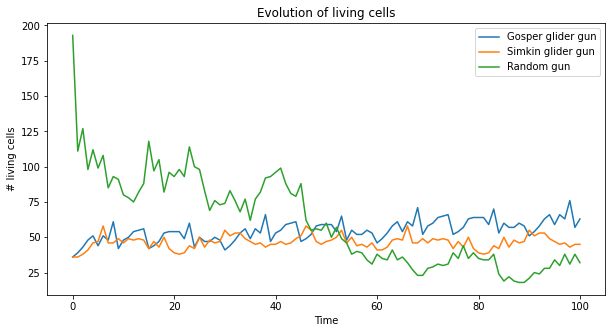

In [45]:
plt.figure(figsize=(10,5))
plt.title('Evolution of living cells')
plt.plot(list(range(101)), gosper_living_cells, label=f'Gosper glider gun')
plt.plot(list(range(101)), simkin_living_cells, label=f'Simkin glider gun')
plt.plot(list(range(101)), random_living_cells, label=f'Random gun')
plt.xlabel('Time')
plt.ylabel('# living cells')
plt.legend()   